# SEC351 - re:Invent 2019 Timeseries Forecasting - Example
## _You should complete the data exploration notebook first_

Load libraries that we will need for the model training and deployment.

In [1]:
# Import important libraries
import pandas as pd
# import numpy as np
import boto3
# import io
# import re
import sagemaker as sage
# from time import gmtime, strftime
# import itertools
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from io import StringIO
# from io import BytesIO
from datetime import datetime

### Import the datset locally and load into the s3 bucket
_This steps assumes you've completed the accompanying data exploration notebook and have created an appropriate csv data file in the local directory_  
We first load the data set into a Pandas DataFrame for feature selection and cleaning. We select those features that are relevant to this forecasting task by manually specifying column names, parse the time, and
- mark all NA values with 0
- drop the first 24 hours

We included optional code to save the data in a CSV file in the local notebook instance. Finally display the first 5 rows to inspect the data frame. 

In [2]:
# We are reading the csv file that we created in the prior data exploration notebook
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

UserEventFreq_df = pd.read_csv('AwsSecurityAudit_Meta31_DescribeDBInstances.csv'
                   , index_col=0)
UserEventFreq_df.index.name = 'date'
UserEventFreq_df.head()

,arn,api,count
date,,,
2019-06-25,arn:aws:sts::002726030336:assumed-role/AwsSecu...,DescribeDBInstances,8
2019-06-26,arn:aws:sts::002726030336:assumed-role/AwsSecu...,DescribeDBInstances,4
2019-06-27,arn:aws:sts::002726030336:assumed-role/AwsSecu...,DescribeDBInstances,8
2019-06-28,arn:aws:sts::002726030336:assumed-role/AwsSecu...,DescribeDBInstances,4
2019-06-29,arn:aws:sts::002726030336:assumed-role/AwsSecu...,DescribeDBInstances,8


In [3]:
dateFreq_df = UserEventFreq_df[['count']]
dateFreq_df.head()

,count
date,
2019-06-25,8
2019-06-26,4
2019-06-27,8
2019-06-28,4
2019-06-29,8


In [4]:
dateFreq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 2019-06-25 to 2019-11-06
Data columns (total 1 columns):
count    135 non-null int64
dtypes: int64(1)
memory usage: 2.1+ KB


#### Store data in S3 
A more persistent data store.  Just in case we close the notebook instance or want to use this data later.  
To upload the data to S3, we define the name of the bucket and the prefix that will be used throughout the notebook. We then create an S3 resource client and upload the data to S3 directly from teh data frame object in memory. 

In [6]:
#Define the s3 bucket
region = boto3.Session().region_name
bucket ='reinvent2019-builder-working' # <==  Change the name of this bucket
prefix = 'data'

In [7]:
# Write data to s3 (rather than keeping in the notebook instance)
s3 = boto3.client("s3")
s3_resource = boto3.resource('s3')

csv_buffer = StringIO()
dateFreq_df.to_csv(csv_buffer)
s3_resource.Object(bucket, prefix+'/data.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '5118D68254EA748F',
  'HostId': '/e20W1mdIUrwZG0DrkppvEX2AN6mrg2ADl/wQcwslu40uk8RQ2ZABlylpQXvhMpazbT1SOehCUA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '/e20W1mdIUrwZG0DrkppvEX2AN6mrg2ADl/wQcwslu40uk8RQ2ZABlylpQXvhMpazbT1SOehCUA=',
   'x-amz-request-id': '5118D68254EA748F',
   'date': 'Fri, 29 Nov 2019 21:37:43 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"10b0a8474462415cd74ab70929bcb151"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"10b0a8474462415cd74ab70929bcb151"',
 'ServerSideEncryption': 'AES256'}

### Visualize the Data
Plot the features in the dataset to observe repeating pattern.

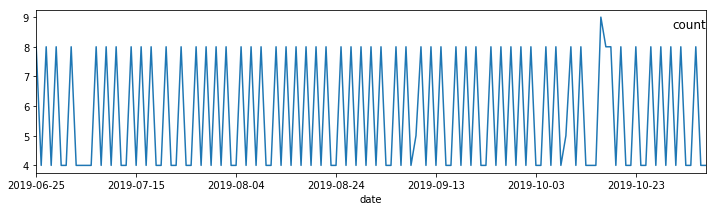

In [8]:
features_of_interest = ['count']
pyplot.figure(figsize=(12,3*len(features_of_interest)))
for i,f in enumerate(features_of_interest):
    if i==0: ax0 = pyplot.subplot(len(features_of_interest), 1, i+1)
    else: pyplot.subplot(len(features_of_interest), 1, i+1, sharex = ax0)
    dateFreq_df[f].plot()
    pyplot.title(f, y=0.85, loc='right')
pyplot.subplots_adjust(hspace=0.05)

### Prepare data for timeseries forecasting
We next define a function that will take timeseries data and create a data structure where input sequence `(t-n, ... t-1)` forecasts an output sequence `(t, t+1, ... t+n)`. This will provide training data for the forecasting algorithm.  

In our simple example, we're just going to use the value at time t to predict the value at time t+1. 

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)  # drop rows with NaN values
    return agg

In [10]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    
    # integer encode direction
    encoder = LabelEncoder()
    raw_values[:,0] = encoder.fit_transform(raw_values[:,0])

    # rescale values to 0, 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(raw_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    # transform into supervised learning problem X, y
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised = supervised[['var1(t-1)',
                             'var1(t)']]
    supervised_values = supervised.values
    # split into train and test sets
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [11]:
timeSeries = dateFreq_df

# configure
n_lag = 1
n_seq = 1
n_test = 30

# prepare data
scaler, train, test = prepare_data(timeSeries, n_test, n_lag, n_seq)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
print(train.shape)

(104, 2)


### Split data into training and testing sets and save in s3

In [13]:
train_df = pd.DataFrame(train)
train_df.head(10)

,0,1
0,0.666667,0.000000
1,0.000000,0.666667
2,0.666667,0.000000
3,0.000000,0.666667
4,0.666667,0.000000
5,0.000000,0.000000
6,0.000000,0.666667
7,0.666667,0.000000
8,0.000000,0.000000
9,0.000000,0.000000


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 2 columns):
0    104 non-null float64
1    104 non-null float64
dtypes: float64(2)
memory usage: 1.7 KB


In [15]:
# select the first 70 observations and save training set in s3:
csv_buffer = StringIO()
train_df[:70].to_csv(csv_buffer,index=False)
s3_resource.Object(bucket, prefix+'/train/train.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'C5D5EADF36712915',
  'HostId': 'f0kHBwk27i0KPvMOmq58WWQfXdJIJN7kf8aO4GwOv+ZtRRf6yAhCCb/7/z1SO8V742HbWNsaXW0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'f0kHBwk27i0KPvMOmq58WWQfXdJIJN7kf8aO4GwOv+ZtRRf6yAhCCb/7/z1SO8V742HbWNsaXW0=',
   'x-amz-request-id': 'C5D5EADF36712915',
   'date': 'Fri, 29 Nov 2019 21:38:09 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"a0b9c9fa336ae6c85ce8f4da8f381234"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a0b9c9fa336ae6c85ce8f4da8f381234"',
 'ServerSideEncryption': 'AES256'}

In [16]:
# save validation set in s3
csv_buffer = StringIO()
train_df[70:].to_csv(csv_buffer,index=False)
s3_resource.Object(bucket, prefix+'/validation/val.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '74AEB9FD6D10553B',
  'HostId': 'wyz8NiwCl8Tk70kpHDfkN+cRyouG7X89OLuxmKGwb/ja/KxM2MlO96PMWf+Iveenkf0NZC7QJe4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'wyz8NiwCl8Tk70kpHDfkN+cRyouG7X89OLuxmKGwb/ja/KxM2MlO96PMWf+Iveenkf0NZC7QJe4=',
   'x-amz-request-id': '74AEB9FD6D10553B',
   'date': 'Fri, 29 Nov 2019 21:38:14 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"68be6bfd7de453a96f4348bad69f6314"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"68be6bfd7de453a96f4348bad69f6314"',
 'ServerSideEncryption': 'AES256'}

### Build the docker image and push it to ECS


In [17]:
%%sh
# Set the name of our algorithm
algorithm_name=reinvent2019-user-event-predict

chmod +x train/train
chmod +x train/serve

# Get the account and region defined in the current configuration (default to us-west-2 if none defined)
account=$(aws sts get-caller-identity --query Account --output text)
region=$(aws configure get region)
region=${region:-us-west-2}
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
sudo docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}
docker push ${fullname}

Login Succeeded

Step 1/9 : FROM nvidia/cuda:9.2-runtime
 ---> 31591a654242
Step 2/9 : MAINTAINER Amazon AI <sage-learner@amazon.com>
 ---> Using cache
 ---> c8f8d16b8fe0
Step 3/9 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> dd94933a980b
Step 4/9 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py &&     pip install numpy==1.16.2 scipy==1.2.1 scikit-learn==0.20.2 keras==2.2.4 tensorflow==1.13.1 pandas==0.24 flask==1.0.2 gevent==1.4.0 gunicorn==19.9.0 &&         (cd /usr/local/lib/python2.7/dist-packages/scipy/.libs; rm *; ln ../../numpy/.libs/* .) &&         rm -rf /root/.cache
 ---> Using cache
 ---> a6de3d731c6a
Step 5/9 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> 9733a1d8b25c
Step 6/9 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Using cache
 ---> 209cd4698b32
Step 7/9 : ENV PATH="/opt/program:${PATH}"
 ---> Usi

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [18]:
traindata_df = pd.read_csv('s3://'+bucket+'/'+prefix+'/train/train.csv')
traindata_df.head()

,0,1
0,0.666667,0.000000
1,0.000000,0.666667
2,0.666667,0.000000
3,0.000000,0.666667
4,0.666667,0.000000


### Train the model and set up the endpoint for inference.

In [19]:
role = sage.get_execution_role()
sess = sage.Session()
source_bucket_uri = 's3://'+bucket+'/'+prefix+'/train/'

# Get account and region to create the image 
# Make sure we're suing the same algorithm name as above
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account, region, 'reinvent2019-user-event-predict')

In [20]:
image

'048848562482.dkr.ecr.us-west-2.amazonaws.com/reinvent2019-user-event-predict:latest'

### Train Model

In [21]:
# Set up SageMaker Estimator and fit the training job
model = sage.estimator.Estimator(image,
                      role, 1, 'ml.p3.8xlarge',
                      output_path="s3://{}/output".format(sess.default_bucket()),
                      sagemaker_session=sess)
model.fit(source_bucket_uri)

2019-11-29 21:39:02 Starting - Starting the training job...
2019-11-29 21:39:03 Starting - Launching requested ML instances......
2019-11-29 21:40:30 Starting - Preparing the instances for training......
2019-11-29 21:41:26 Downloading - Downloading input data...
2019-11-29 21:41:56 Training - Downloading the training image......
2019-11-29 21:43:04 Uploading - Uploading generated training modelUsing TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2019-11-29 21:42:46.971898: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-11-29 21:42:47.012936: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300045000 Hz
2019-11-29 21:42:47.014915: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x63303c0 executing computations on platform Host. Devices:
2019-11-29 21:42:

### Create endpoint

In [22]:
# Create the model endpoint 
predictor = model.deploy(1, 'ml.t2.medium', serializer=sage.predictor.csv_serializer)

-------------------------------------------------------------------------------------------------------------!

In [24]:
predictor

### Test that the endpoint is working and make predictions

In [25]:
type(test)

numpy.ndarray

In [26]:
test.shape

(30, 2)

In [27]:
testData_df = pd.DataFrame(test)

In [28]:
testData_df.head()

,0,1
0,0.666667,0.000000
1,0.000000,0.333333
2,0.333333,0.666667
3,0.666667,0.000000
4,0.000000,0.666667


In [29]:
testData_df=testData_df.iloc[:,:1]
testData_df.head()

,0
0,0.666667
1,0.000000
2,0.333333
3,0.666667
4,0.000000


#### Aside - Testing the endpoint outside the notebook
In the previous (and following) code, we call the model endpoint inference from within the notebook environment.  The more common use-case, however, is calling the endpoint in some account-local application.  For this, we'll use the _invoke_endpoint()_ API call. For example, we might call it from a lambda.  
So, before we proceed, we just want to check that that API call works properly.

In [30]:
import io
payload = pd.read_csv('simpfile.csv')
payload_file = io.StringIO()
payload.to_csv(payload_file, header = None, index = None)

In [31]:
import boto3
client = boto3.client('sagemaker-runtime')
response = client.invoke_endpoint(
    EndpointName = 'reinvent2019-user-event-predict-2019-11-29-21-39-02-296', 
    ContentType = 'text/csv',
    Body = payload_file.getvalue())

In [32]:
import json
result = json.loads(response['Body'].read().decode())
print(result)

JSONDecodeError: Extra data: line 2 column 1 (char 13)

#### End of aside....

#### Testing and scoring unseen data
Let's return to testing our new time series predictor, and see how we could score new points.

In [33]:
sess = sage.Session()

In [34]:
testData_df.values

array([[0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.        ],
       [0.        ],
       [1.        ],
       [0.66666667],
       [0.66666667],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.66666667],
       [0.        ],
       [0.        ],
       [0.66666667],
       [0.        ]])

In [35]:
predictions = predictor.predict(testData_df.values).decode('utf-8').split('\n')

In [36]:
predictions

['0.0014204755',
 '0.48612335',
 '0.22450905',
 '0.0014204755',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.48612335',
 '0.48612335',
 '-0.15971607',
 '0.0014204755',
 '0.0014204755',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '0.48612335',
 '0.0014204755',
 '0.48612335',
 '']

In [37]:
type(predictions[1])

str

In [38]:
n_features = 1
actual = [row[n_features:] for row in test]

In [39]:
forecasts = list()
for i in range(len(test)):
    # make forecast
    forecast = [float(s) for s in predictions[i].split(',')]
    # store the forecast
    forecasts.append(forecast)

#### Calculate RMSE in scaled and unscaled features space

In [40]:
# evaluate the RMSE for each forecast time step
from sklearn.metrics import mean_squared_error

def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.331012


In [43]:
#transform back to the original scale
raw_values = timeSeries.values

# transform into supervised learning problem X, y
supervised = series_to_supervised(raw_values, n_lag, n_seq)
supervised = supervised[['var1(t)']]
supervised_values = supervised.values

# rescale values back to the original values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(supervised_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

inv_forecast = scaler.inverse_transform(forecasts)
inv_actual = scaler.inverse_transform(actual)

evaluate_forecasts(inv_actual, inv_forecast, n_lag, n_seq)

t+1 RMSE: 0.993035


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
    # plot the entire dataset in blue
    pyplot.figure(figsize=(20,5))
    pyplot.plot(series.values)
    # plot the forecasts in red
    for i in range(len(forecasts)):
        off_s = len(series) - n_test + i -1
        off_e = off_s + len(forecasts[i]) +1
        xaxis = [x for x in range(off_s, off_e)]
        yaxis = [series.values[off_s]] + list(forecasts[i]) 
        pyplot.plot(xaxis, yaxis, color='red')
    # show the plot
    pyplot.show()

In [45]:
polution = dateFreq_df['count'][-32:]
polution

date
2019-10-06    0
2019-10-07    2
2019-10-08    0
2019-10-09    1
2019-10-10    2
2019-10-11    0
2019-10-12    2
2019-10-13    0
2019-10-14    0
2019-10-15    0
2019-10-16    3
2019-10-17    2
2019-10-18    2
2019-10-19    0
2019-10-20    2
2019-10-21    0
2019-10-22    0
2019-10-23    2
2019-10-24    0
2019-10-25    0
2019-10-26    2
2019-10-27    0
2019-10-28    2
2019-10-29    0
2019-10-30    2
2019-10-31    0
2019-11-01    2
2019-11-02    0
2019-11-03    0
2019-11-04    2
2019-11-05    0
2019-11-06    0
Name: count, dtype: int64

### Graph of original series

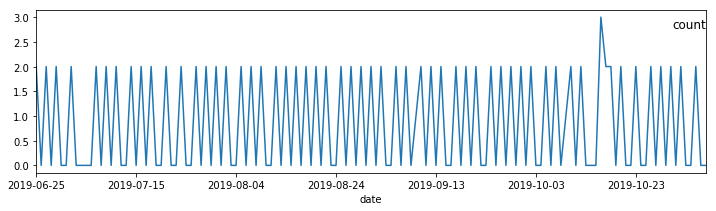

In [47]:
features_of_interest = ['count']
pyplot.figure(figsize=(12,3*len(features_of_interest)))
for i,f in enumerate(features_of_interest):
    if i==0:
        ax0 = pyplot.subplot(len(features_of_interest), 1, i+1)
    else:
        pyplot.subplot(len(features_of_interest), 1, i+1, sharex = ax0)
    dateFreq_df[f].plot()
    pyplot.title(f, y=0.85, loc='right')
pyplot.subplots_adjust(hspace=0.05)

### Graph of forecast on last 30 days of dataset

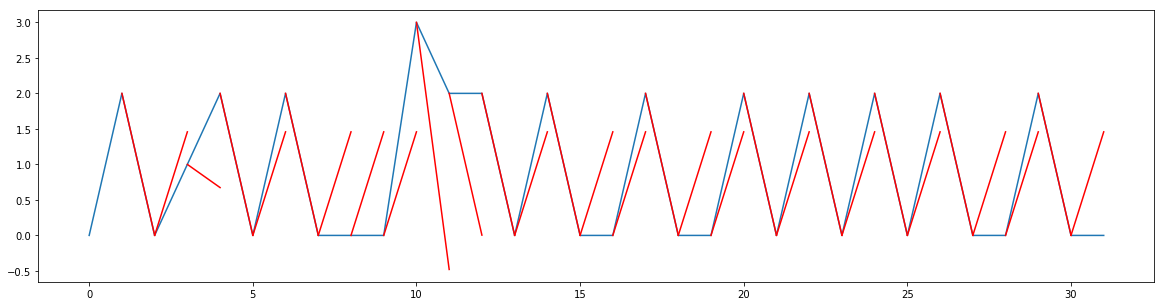

In [48]:
plot_forecasts(polution, inv_forecast, 30)

### Graph errors to determine if our ongoing series has an anomoly. Higher than normal error = anomoly

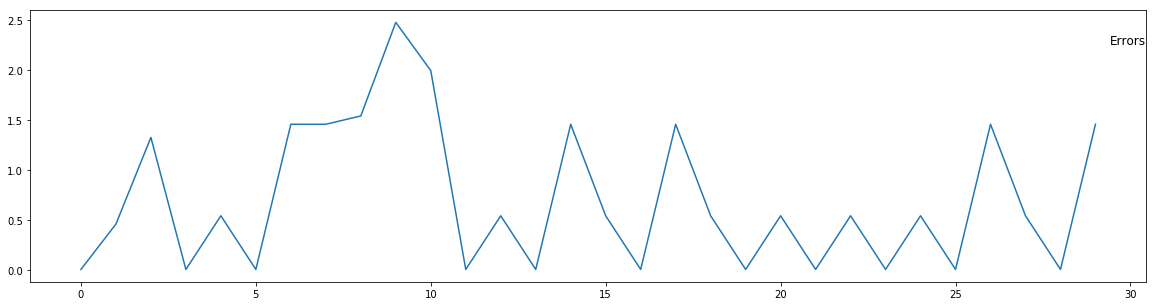

In [49]:
errors = abs(inv_actual - inv_forecast)
pyplot.figure(figsize=(20,5))
pyplot.plot(errors)
pyplot.title('Errors', y=0.85, loc='right')
pyplot.show()

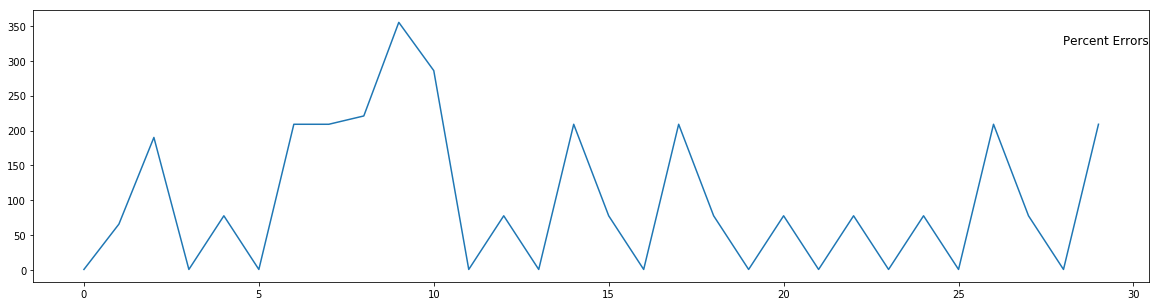

In [50]:
import numpy as np
errors = abs(inv_actual - inv_forecast)
mean_error = np.mean(errors)
pct_error = errors / mean_error * 100
std_error = np.std(errors)
pyplot.figure(figsize=(20,5))
pyplot.plot(pct_error)
pyplot.title('Percent Errors', y=0.85, loc='right')
pyplot.show()

In [51]:
std_error

0.7066191284007535

In [ ]:
# delete endpoint so you avoid any recuring charges
sess.delete_endpoint(predictor.endpoint)